In [30]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from datetime import datetime

In [31]:
#Inputs of the desired data if don't want to change it manually 
input_tickers = ['AMD']
main_ticker = ['AMD'] 
start_date_input = '2016-1-1'
index = '^GSPC'
simulations = 20000
trading_days = 252
rf_rate = 0

In [32]:
#IMPORTING DATA FROM YAHOO FINANCE
def import_stock_data(tickers, start, end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

data = import_stock_data(tickers = main_ticker, start = start_date_input)


In [33]:
#CALCULATING LOG RETURNS 
def log_returns(data):
    return (np.log(1+data.pct_change()))
log_return = log_returns(data)

#CALCULATING SIMPLE RETURNS 
def simple_returns(data):
    return ((data/data.shift(1))-1)
    

In [34]:
#CAPM AND SHARPE
def market_data_combination(data, mark_ticker, start):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return


In [35]:
def beta_sharpe(data, mark_ticker = index, start=start_date_input, riskfree = rf_rate):
    
    """
    Input: 

    riskfree: the assumed risk free yield (US 10 Year Bond is assumed: 2.5%)
    
    Output:
    1. Dataframe with CAPM metrics computed against specified market procy
    """
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start)
    log_ret = log_returns(dd)
    covar = log_ret.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    mrk_var = log_ret.iloc[:,-1].var()*252
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*252**0.5)[:-1]), columns=['STD'])

    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={index:"Beta"}, inplace=True)
    
    return beta

capm_sharpe = pd.DataFrame(data = beta_sharpe(data))


In [36]:
#Browinan Motion
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift
drift_calc(data)


array([0.00198789])

In [37]:
#Monte Carlo Returns 
def daily_returns(data, days, iterations, return_type='log'):
    ft = drift_calc(data, return_type)
    if return_type == 'log':
        try:
            stv = log_returns(data).std().values
        except:
            stv = log_returns(data).std()
    elif return_type=='simple':
        try:
            stv = simple_returns(data).std().values
        except:
            stv = simple_returns(data).std()    
    #Oftentimes, we find that the distribution of returns is a variation of the normal distribution where it has a fat tail
    # This distribution is called cauchy distribution
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, iterations)))
    return dr
dr = daily_returns(data, 2, 3)


/Users/leftstories/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leftstories/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


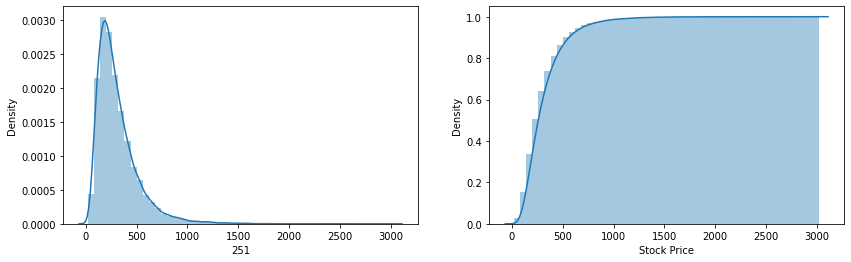

AMD
Days: 251
Expected Value: $309.88
Return: 49.52%
Probability of Breakeven: 0.79555


,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,156.412994,156.412994,156.412994,156.412994,156.412994,156.412994,156.412994,156.412994,156.412994,156.412994,...,156.412994,156.412994,156.412994,156.412994,156.412994,156.412994,156.412994,156.412994,156.412994,156.412994
1,167.029245,165.228476,164.108269,157.641830,151.267016,157.873799,165.108934,160.323392,161.854624,158.542185,...,162.129476,150.078361,167.063367,158.889308,149.031824,161.923361,165.778130,155.938396,161.560199,163.479420
2,167.022850,167.602147,152.385077,148.941796,150.026936,162.655403,170.880292,168.859208,165.285296,161.186504,...,166.225669,150.730678,168.332883,154.004022,141.135119,155.790371,169.676121,165.083899,164.070995,158.042480
3,163.599619,162.150308,148.972549,150.177818,154.132200,164.289669,178.623438,171.163411,165.746050,173.631115,...,165.512060,153.472484,170.047724,154.585171,133.630272,152.986249,171.669115,182.382828,177.610097,159.328942
4,173.748159,164.017856,149.692109,149.265937,156.922491,143.046682,174.211986,168.046689,161.256857,175.667326,...,173.823955,161.684791,169.999788,158.515833,135.087164,161.007053,163.782329,180.334987,173.938164,158.761810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,525.111953,601.775849,74.325365,269.217788,213.959060,342.072635,94.859415,136.428849,683.616720,567.287800,...,765.748481,811.342886,210.041077,94.874290,518.534929,639.839010,99.753805,290.974422,249.514072,90.459730
248,525.535666,596.296503,71.584134,280.510895,216.785991,352.935806,99.564496,139.118342,672.608332,570.629269,...,765.425790,787.299460,212.550993,93.855245,514.815733,646.957054,101.785582,290.726563,238.119577,91.594602
249,511.920673,629.853656,70.988798,289.783386,211.129212,355.041674,101.130337,139.173615,664.824227,549.846191,...,805.145882,820.931255,222.107256,100.145682,510.023837,676.875471,106.945199,267.292357,241.237394,96.662698
250,532.046266,637.895786,72.592568,269.990064,207.234187,335.173402,98.397015,140.029483,670.243203,557.498634,...,799.437173,794.941290,210.517593,99.280385,493.977454,654.500529,107.249957,271.694760,244.574396,97.505737


In [38]:
def probs_find(predicted, higherthan, on = 'value'):
    """
    This function calculated the probability of a stock being above a certain threshhold, which can be defined as a value (final stock price) or return rate (percentage change)
    Input: 
    1. predicted: dataframe with all the predicted prices (days and simulations)
    2. higherthan: specified threshhold to which compute the probability (ex. 0 on return will compute the probability of at least breakeven)
    3. on: 'return' or 'value', the return of the stock or the final value of stock for every simulation over the time specified
    """
    if on == 'return':
        predicted0 = predicted.iloc[0,0]
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
        less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
    elif on == 'value':
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    else:
        print("'on' must be either value or return")
    return (len(over)/(len(over)+len(less)))

def simulate_mc(data, days, iterations, return_type='log', plot=True):
    # Generate daily returns
    returns = daily_returns(data, days, iterations, return_type)
    # Create empty matrix
    price_list = np.zeros_like(returns)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for t in range(1,days):
        price_list[t] = price_list[t-1]*returns[t]
    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(price_list).iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
    
    #CAPM and Sharpe Ratio
    
    # Printing information about stock
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)
    print(f"Days: {days-1}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
    print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
          
    return pd.DataFrame(price_list)
simulate_mc(data, days = trading_days, iterations = simulations, return_type = 'log')


/Users/leftstories/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leftstories/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


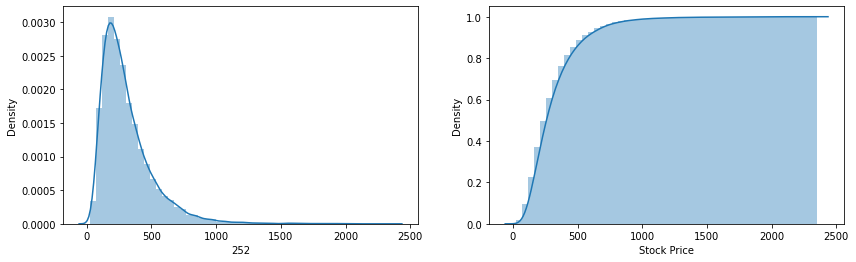

AMD
Days: 252
Expected Value: $310.03
Return: 49.57%
Probability of Breakeven: 0.798
         Beta       STD      CAPM    Sharpe
AMD  1.493224  0.605128  0.225708  0.372991
Beta: 1.49
Sharpe: 0.37
CAPM Return: 22.57%


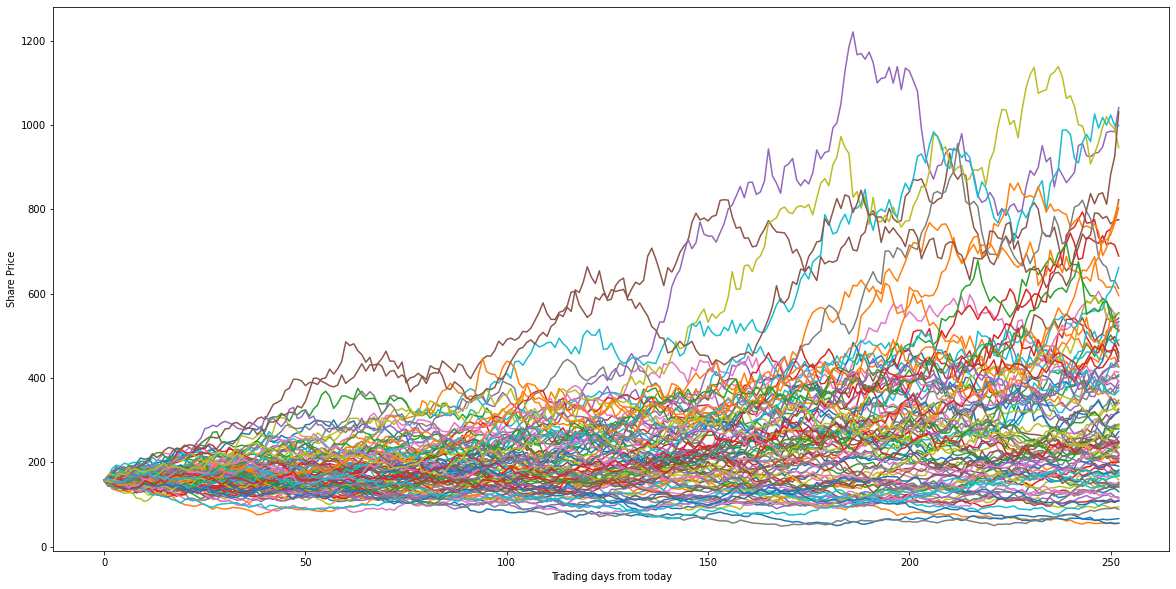

In [39]:
def monte_carlo(tickers, days_forecast, iterations, start_date, return_type = 'log', plotten=True):
    data = import_stock_data(input_tickers, start=start_date_input)
    inform = beta_sharpe(data, mark_ticker=index, start=start_date_input)
    simulatedDF = []
    for t in range(len(tickers)):
        y = simulate_mc(data.iloc[:,t], (days_forecast+1), iterations, return_type)
        if plotten == True:
            forplot = y.iloc[:,0:100]
            forplot.plot(figsize=(20,10), legend = None, xlabel = 'Trading days from today', ylabel = 'Share Price')
        print(inform)
        print(f"Beta: {round(inform.iloc[t,inform.columns.get_loc('Beta')],2)}")
        print(f"Sharpe: {round(inform.iloc[t,inform.columns.get_loc('Sharpe')],2)}") 
        print(f"CAPM Return: {round(100*inform.iloc[t,inform.columns.get_loc('CAPM')],2)}%")
        
        y['ticker'] = tickers[t]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
        simulatedDF = pd.concat(simulatedDF)
    return simulatedDF


ret_sim_df = monte_carlo(input_tickers, days_forecast= trading_days, iterations=simulations,  start_date=start_date_input, plotten=True)

